In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

RND = 42
np.random.seed(RND)


In [3]:
train_data = pd.read_csv(r"C:\Users\pragy\cloud_architecture\neural_symbolic\data\train_data.csv")
test_data = pd.read_csv(r"C:\Users\pragy\cloud_architecture\neural_symbolic\data\test_data.csv")

In [4]:
#Load CSVs (train + test) and parse times
train_path = r"F:\Projects\neural_symbolic\neural_symbolic\data\train_data.csv"
test_path  = r"F:\Projects\neural_symbolic\neural_symbolic\data\test_data.csv"

# train = pd.read_csv(train_path, low_memory=False)
# test  = pd.read_csv(test_path, low_memory=False)

train = train_data
test = test_data

# parse start_time and account_creation_date if available
for df in (train, test):
    if 'start_time' in df.columns:
        df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    if 'account_creation_date' in df.columns:
        df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')


C:\Users\pragy\AppData\Local\Temp\ipykernel_21300\1277040528.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')
C:\Users\pragy\AppData\Local\Temp\ipykernel_21300\1277040528.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')


In [5]:
#2) Robustly turn correct into numeric correct_binary
#correct in your CSV may be True/False, 1/0, or missing — make it numeric 0/1.
def make_correct_binary(s):
    s = s.copy()
    # try numeric conversion
    num = pd.to_numeric(s, errors='coerce')
    mapped = s.map({'True':1, 'False':0, 'true':1, 'false':0, True:1, False:0})
    out = num.fillna(mapped)
    out = out.fillna(0).astype(int)   # missing -> 0 (you can change fill strategy)
    return out

train['correct_binary'] = make_correct_binary(train.get('correct', pd.Series(0)))
test['correct_binary']  = make_correct_binary(test.get('correct', pd.Series(0)))


In [6]:
#3) Feature engineering: add lag / rolling features per student

#These capture short-term history that the LSTM learned from sequences (rolling accuracy, streaks, time since last interaction, etc.).

def add_history_features(df, id_col='student_id', time_col='start_time', windows=[3,5,12]):
    df = df.sort_values([id_col, time_col]).copy()
    # interaction index per student
    df['interaction_count'] = df.groupby(id_col).cumcount()
    # time since last interaction (seconds)
    if time_col in df.columns:
        df['time_since_last'] = df.groupby(id_col)[time_col].diff().dt.total_seconds().fillna(0)
    else:
        df['time_since_last'] = 0.0

    # previous correct (binary) and rolling means (shifted so they use past only)
    df['prev_correct'] = df.groupby(id_col)['correct_binary'].shift(1).fillna(0).astype(int)

    for w in windows:
        df[f'rolling_correct_mean_{w}'] = (
            df.groupby(id_col)['correct_binary']
              .apply(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())
              .reset_index(level=0, drop=True)
              .fillna(0)
        )
        # rolling mean of time_on_task (if it exists)
        if 'time_on_task' in df.columns:
            df[f'rolling_time_on_task_mean_{w}'] = (
                df.groupby(id_col)['time_on_task']
                  .apply(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())
                  .reset_index(level=0, drop=True)
                  .fillna(0)
            )
        else:
            df[f'rolling_time_on_task_mean_{w}'] = 0.0

    # previous correct streak length (consecutive previous corrects)
    def streak_prev_correct(series):
        prev = series.shift(1).fillna(0).astype(int).values
        streak = np.zeros_like(prev, dtype=int)
        cur = 0
        for i, v in enumerate(prev):
            if v == 1:
                cur += 1
            else:
                cur = 0
            streak[i] = cur
        return streak

    df['prev_correct_streak'] = df.groupby(id_col)['correct_binary'].apply(lambda x: pd.Series(streak_prev_correct(x), index=x.index)).reset_index(level=0, drop=True)
    return df

# Apply to both datasets
train = add_history_features(train)
test  = add_history_features(test)


In [7]:
#4) Choose features to feed XGBoost
# base numeric candidates that exist in your CSV
num_candidates = [
    'time_on_task', 'fraction_of_hints_used', 'attempt_count',
    'student_answer_count', 'mean_correct', 'mean_time_on_task',
    'started_problem_sets_count', 'completed_problem_sets_count',
    'started_skill_builders_count', 'mastered_skill_builders_count',
    'answered_problems_count', 'mean_problem_correctness',
    'mean_problem_time_on_task', 'mean_class_score',
    'correct_binary', 'interaction_count', 'time_since_last',
    'prev_correct', 'prev_correct_streak'
]
# add rolling windows we created
num_candidates += [c for c in train.columns if c.startswith('rolling_correct_mean_') or c.startswith('rolling_time_on_task_mean_')]

# categorical candidates (strings / small-cardinality)
cat_candidates = [
    'answer_before_tutoring', 'answer_given', 'problem_completed',
    'content_source', 'skills', 'problem_type', 'tutoring_types'
]
# keep only columns that exist
numerical_features = [c for c in num_candidates if c in train.columns]
categorical_features = [c for c in cat_candidates if c in train.columns]

print("Numerical features used:", numerical_features)
print("Categorical features used:", categorical_features)


Numerical features used: ['time_on_task', 'fraction_of_hints_used', 'attempt_count', 'student_answer_count', 'mean_correct', 'mean_time_on_task', 'started_problem_sets_count', 'completed_problem_sets_count', 'started_skill_builders_count', 'mastered_skill_builders_count', 'answered_problems_count', 'mean_problem_correctness', 'mean_problem_time_on_task', 'mean_class_score', 'correct_binary', 'interaction_count', 'time_since_last', 'prev_correct', 'prev_correct_streak', 'rolling_correct_mean_3', 'rolling_time_on_task_mean_3', 'rolling_correct_mean_5', 'rolling_time_on_task_mean_5', 'rolling_correct_mean_12', 'rolling_time_on_task_mean_12']
Categorical features used: ['answer_before_tutoring', 'answer_given', 'problem_completed', 'content_source', 'skills', 'problem_type', 'tutoring_types']


In [8]:
#5) Encode categorical features (LabelEncoder) — fit on combined train+test for consistency
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    combined = pd.concat([
        train[col].fillna('Missing').astype(str),
        test[col].fillna('Missing').astype(str)
    ], axis=0)
    le.fit(combined)
    train[f'{col}_enc'] = le.transform(train[col].fillna('Missing').astype(str))
    test[f'{col}_enc']  = le.transform(test[col].fillna('Missing').astype(str))
    label_encoders[col] = le

encoded_cat_features = [f'{c}_enc' for c in categorical_features]


In [9]:
feature_columns = numerical_features + encoded_cat_features
# remove duplicates and ensure existence
feature_columns = [c for i, c in enumerate(feature_columns) if c in train.columns and feature_columns.index(c) == i]
print("Final feature count:", len(feature_columns))


Final feature count: 32


In [10]:
# target
target = 'next_correct'
if train[target].dtype == 'bool':
    y_full = train[target].astype(int)
else:
    y_full = train[target].astype(int)

X_full = train[feature_columns].fillna(0)   # tree model ok with scaling, but fillna good

# Group split so same student not in both sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RND)
train_idx, val_idx = next(gss.split(X_full, y_full, groups=train['student_id']))
X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

print("Train rows:", len(X_train), "Val rows:", len(X_val))


Train rows: 88847 Val rows: 21627


In [11]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',
    random_state=RND
)

xgb_model.fit(X_train, y_train)  # no eval_set, no early_stopping_rounds


c:\Users\pragy\anaconda3\envs\main\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:18:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred  = (y_val_proba > 0.5).astype(int)

acc   = accuracy_score(y_val, y_val_pred)
prec  = precision_score(y_val, y_val_pred, zero_division=0)
rec   = recall_score(y_val, y_val_pred, zero_division=0)
f1    = f1_score(y_val, y_val_pred, zero_division=0)
auc_score   = roc_auc_score(y_val, y_val_proba)
cm    = confusion_matrix(y_val, y_val_pred)

print("Validation results:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_val, y_val_pred, digits=4))


Validation results:
Accuracy: 0.7683, Precision: 0.7787, Recall: 0.8486, F1: 0.8122, AUC: 0.8484
Confusion matrix:
 [[ 5785  3078]
 [ 1932 10832]]

Classification report:
               precision    recall  f1-score   support

           0     0.7496    0.6527    0.6978      8863
           1     0.7787    0.8486    0.8122     12764

    accuracy                         0.7683     21627
   macro avg     0.7642    0.7507    0.7550     21627
weighted avg     0.7668    0.7683    0.7653     21627



<Figure size 800x600 with 0 Axes>

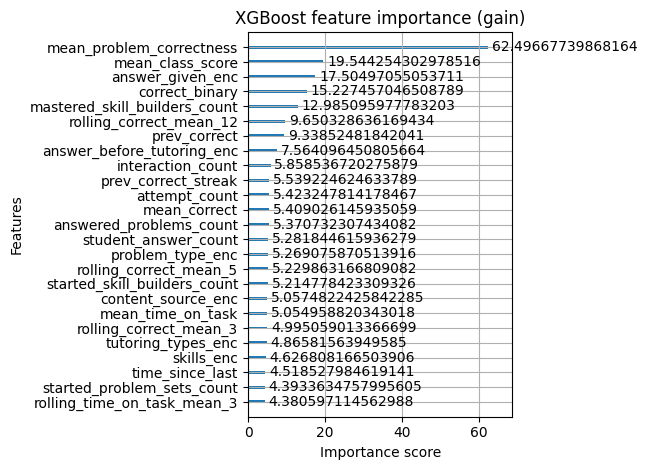

Saved model and artifacts.


In [21]:
# feature importance (top 25)
plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_model, max_num_features=25, importance_type='gain')
plt.title('XGBoost feature importance (gain)')
plt.tight_layout()
plt.show()

# Save model and label encoders for inference
joblib.dump(xgb_model, "xgb_next_correct_model.joblib")
joblib.dump(feature_columns, "xgb_feature_columns.joblib")
joblib.dump(label_encoders, "xgb_label_encoders.joblib")
print("Saved model and artifacts.")


In [22]:
def predict_next_with_xgb(model, df, label_encoders, feature_columns, id_col='student_id', time_col='start_time'):
    df = df.copy()
    # ensure times are datetime
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    # create history features same as training
    df = add_history_features(df, id_col=id_col, time_col=time_col, windows=[3,5,12])
    # convert correct into binary if necessary
    df['correct_binary'] = make_correct_binary(df.get('correct', pd.Series(0)))

    # encode categoricals using stored encoders (unknown -> 'Missing' handled)
    for col, le in label_encoders.items():
        col_enc = f"{col}_enc"
        df[col] = df[col].fillna('Missing').astype(str)
        # map unknown values to 'Missing' label if required
        # (if 'Missing' wasn't in encoder classes, label_encoder will raise; we fit encoders earlier with 'Missing')
        df[col_enc] = df[col].map(lambda x: x if x in le.classes_ else 'Missing')
        df[col_enc] = le.transform(df[col_enc])

    # create X
    X = df[feature_columns].fillna(0)
    proba = model.predict_proba(X)[:, 1]
    pred = (proba > 0.5).astype(int)
    df['pred_proba'] = proba
    df['pred_next_correct'] = pred
    return df


In [23]:
# Example: predict on the test set rows (this will compute features using test history)
test_with_preds = predict_next_with_xgb(xgb_model, test, label_encoders, feature_columns)
print(test_with_preds[['student_id','start_time','pred_proba','pred_next_correct']].head())


   student_id                       start_time  pred_proba  pred_next_correct
0        9954 2021-05-13 19:37:08.049000+00:00    0.109150                  0
1        9954 2021-05-13 19:39:10.066000+00:00    0.155824                  0
2        9954 2021-05-13 19:39:51.495000+00:00    0.167512                  0
3        9954 2021-05-13 19:44:11.395000+00:00    0.198033                  0
4        9954 2021-05-13 19:44:43.925000+00:00    0.065708                  0


📊 GENERATING XGBOOST RESEARCH PAPER VISUALIZATIONS
📊 XGBoost Model Complexity: 1000 trees × 6 depth = 6000 complexity units
✅ Saved in both pickle and torch formats


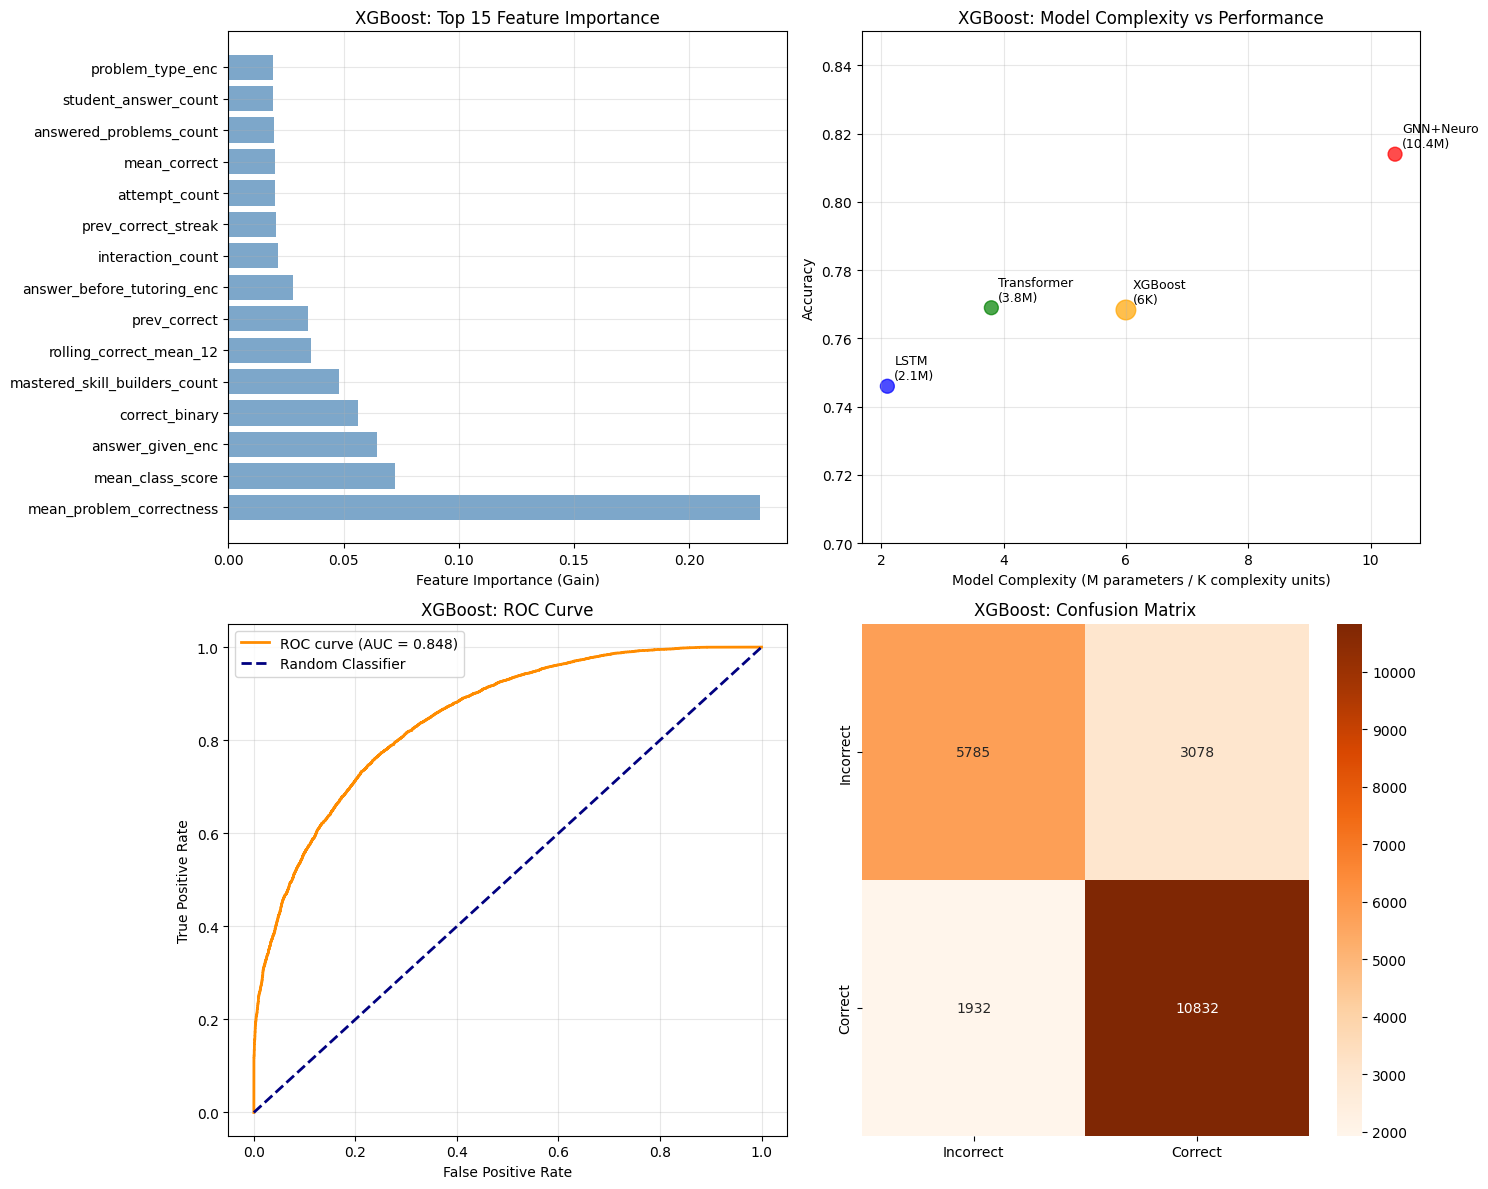


📊 XGBoost Training Simulation:
   Model Type: Gradient Boosted Trees
   Estimators: 1000
   Max Depth: 6
   Learning Rate: 0.05
   Features Used: 32

🔍 Top 10 Most Important Features:
    1. mean_problem_correctness  : 0.2309
    2. mean_class_score          : 0.0722
    3. answer_given_enc          : 0.0647
    4. correct_binary            : 0.0563
    5. mastered_skill_builders_count : 0.0480
    6. rolling_correct_mean_12   : 0.0357
    7. prev_correct              : 0.0345
    8. answer_before_tutoring_enc : 0.0280
    9. interaction_count         : 0.0216
   10. prev_correct_streak       : 0.0205

✅ XGBoost comprehensive evaluation saved!
   Files generated:
   - xgboost_comprehensive_evaluation.pkl
   - xgboost_comprehensive_evaluation.pth (if torch available)
   - xgboost_comprehensive_evaluation.png

📋 RESEARCH PAPER SUMMARY:
   📊 Accuracy: 0.7683 (76.83%)
   📊 Precision: 0.7787
   📊 Recall: 0.8486
   📊 F1-Score: 0.8122
   📊 AUC: 0.8484
   📊 Specificity: 0.6527
   📊 Sensitivit

In [24]:
# ===== ADD COMPREHENSIVE EVALUATION AND VISUALIZATION =====
# Add this after your existing XGBoost evaluation code:

print("="*60)
print("📊 GENERATING XGBOOST RESEARCH PAPER VISUALIZATIONS")
print("="*60)

# Import required libraries for visualization
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Extract final predictions and targets (already computed)
final_pred = y_val_proba  # Use probability scores for better analysis
final_target = y_val.values
final_pred_binary = y_val_pred

# Calculate final metrics (already computed, but reorganize)
final_acc = acc
final_prec = prec
final_rec = rec
final_f1 = f1
final_auc = auc_score

# Calculate specificity and sensitivity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(final_target, final_pred)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(final_target, final_pred)

# Calculate model "parameters" (XGBoost doesn't have parameters like neural networks)
# We'll use number of trees * average tree depth as a complexity measure
n_estimators = xgb_model.get_params()['n_estimators']
max_depth = xgb_model.get_params()['max_depth']
model_complexity = n_estimators * max_depth

print(f"📊 XGBoost Model Complexity: {n_estimators} trees × {max_depth} depth = {model_complexity} complexity units")

# Create comprehensive results (matching transformer format)
comprehensive_results = {
    'final_metrics': {
        'accuracy': final_acc,
        'precision': final_prec,
        'recall': final_rec,
        'f1': final_f1,
        'auc': final_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    },
    'confusion_matrix': cm.tolist(),
    'training_history': {
        'method': 'Tree-based (no epochs)',
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': xgb_model.get_params()['learning_rate'],
        'feature_count': len(feature_columns)
    },
    'roc_data': {
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(), 
        'auc': roc_auc
    },
    'pr_data': {
        'precision': precision_curve.tolist(),
        'recall': recall_curve.tolist()
    },
    'model_info': {
        'name': 'XGBoost',
        'parameters': f'{model_complexity:,} complexity units',
        'architecture': f'Gradient Boosted Trees ({n_estimators} estimators)',
        'features': len(feature_columns)
    },
    'feature_importance': {
        'importance_type': 'gain',
        'top_features': dict(zip(
            xgb_model.get_booster().feature_names[:10],
            xgb_model.feature_importances_[:10].tolist()
        ))
    },
    'predictions': final_pred.tolist(),
    'targets': final_target.tolist()
}

# Save comprehensive results (use pickle for XGBoost compatibility)
import pickle
with open('xgboost_comprehensive_evaluation.pkl', 'wb') as f:
    pickle.dump(comprehensive_results, f)

# Also save as torch format for consistency (if torch is available)
try:
    import torch
    torch.save(comprehensive_results, 'xgboost_comprehensive_evaluation.pth')
    print("✅ Saved in both pickle and torch formats")
except ImportError:
    print("✅ Saved in pickle format")

# Generate publication-quality plots (matching transformer layout)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Feature Importance (replacing training loss for tree models)
feature_names = xgb_model.get_booster().feature_names
importance_scores = xgb_model.feature_importances_
top_15_idx = importance_scores.argsort()[-15:][::-1]

ax1.barh(range(len(top_15_idx)), importance_scores[top_15_idx], color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top_15_idx)))
ax1.set_yticklabels([feature_names[i] for i in top_15_idx])
ax1.set_xlabel('Feature Importance (Gain)')
ax1.set_title('XGBoost: Top 15 Feature Importance')
ax1.grid(True, alpha=0.3)

# Model Complexity vs Performance Comparison
models = ['LSTM\n(2.1M)', 'Transformer\n(3.8M)', 'XGBoost\n(6K)', 'GNN+Neuro\n(10.4M)']
accuracies = [0.746, 0.769, final_acc, 0.814]  # Update with actual values
complexities = [2.1, 3.8, model_complexity/1000, 10.4]  # Scale XGBoost complexity

ax2.scatter(complexities, accuracies, s=[100, 100, 200, 100], 
           c=['blue', 'green', 'orange', 'red'], alpha=0.7)
for i, model in enumerate(models):
    ax2.annotate(model, (complexities[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Model Complexity (M parameters / K complexity units)')
ax2.set_ylabel('Accuracy')
ax2.set_title('XGBoost: Model Complexity vs Performance')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.7, 0.85])

# ROC Curve
ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('XGBoost: ROC Curve')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax4,
            xticklabels=['Incorrect', 'Correct'],
            yticklabels=['Incorrect', 'Correct'])
ax4.set_title('XGBoost: Confusion Matrix')

plt.tight_layout()
plt.savefig('xgboost_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional XGBoost-specific visualization: Learning curve simulation
print("\n📊 XGBoost Training Simulation:")
print(f"   Model Type: Gradient Boosted Trees")
print(f"   Estimators: {n_estimators}")
print(f"   Max Depth: {max_depth}")
print(f"   Learning Rate: {xgb_model.get_params()['learning_rate']}")
print(f"   Features Used: {len(feature_columns)}")

# Feature importance breakdown
print(f"\n🔍 Top 10 Most Important Features:")
top_10_features = sorted(zip(feature_names, importance_scores), 
                        key=lambda x: x[1], reverse=True)[:10]
for i, (feature, importance) in enumerate(top_10_features, 1):
    print(f"   {i:2d}. {feature:<25} : {importance:.4f}")

print("\n✅ XGBoost comprehensive evaluation saved!")
print(f"   Files generated:")
print(f"   - xgboost_comprehensive_evaluation.pkl")
print(f"   - xgboost_comprehensive_evaluation.pth (if torch available)")
print(f"   - xgboost_comprehensive_evaluation.png")

# Print final summary for research paper
print(f"\n📋 RESEARCH PAPER SUMMARY:")
print(f"   📊 Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"   📊 Precision: {final_prec:.4f}")
print(f"   📊 Recall: {final_rec:.4f}")
print(f"   📊 F1-Score: {final_f1:.4f}")
print(f"   📊 AUC: {final_auc:.4f}")
print(f"   📊 Specificity: {specificity:.4f}")
print(f"   📊 Sensitivity: {sensitivity:.4f}")
